1. import libraries

In [15]:
#import 
%run 0_function.ipynb
# from function import yyplot_k, boruta, search_highly_correlated_variables

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error

2. Setting

In [16]:
#random seed
rseed_cv = 42
rseed_boruta = 1
rseed_model = 2

In [17]:
#select dataset, monomer, descriptors
data_set = "1&2" #1&2
monomer = "St" #St or nBA
descriptors = "morganFP" #morganFP

3. Run model

Sheet 'St' not found. Loading the first sheet instead.


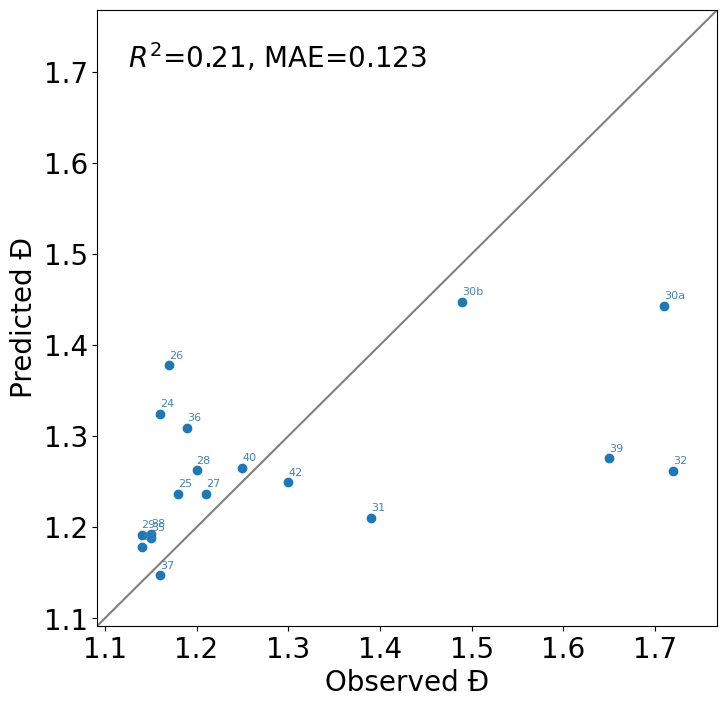

In [18]:
if __name__ == "__main__":
    # file & preprocessing
    try:     
        df_X = pd.read_excel("../data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(data_set, data_set, descriptors), index_col = 0, sheet_name = monomer) #descriptors select
    except ValueError:
        print(f"Sheet '{monomer}' not found. Loading the first sheet instead.")
        df_X = pd.read_excel("../data/XY/data_set_{}/data_set_{}_{}_descriptors.xlsx".format(data_set, data_set, descriptors), index_col = 0)
        
    df_Y = pd.read_excel("../data/XY/data_set_{}/data_set_{}_SMILES&objective_function.xlsx".format(data_set, data_set), index_col = 0)
    
    df = pd.concat([df_X, df_Y], axis=1)
    
    df.index = df.index.astype("str")
    df.drop(["41"], axis=0, inplace=True) #Select the sample you want to use
    X = df.iloc[:, :len(df_X.columns)]
    y = np.log(df["{}_PDI".format(monomer)]-1) # St_PDI or nBA_PDI
    
    fold = len(df.index)
    kf = KFold(n_splits=fold, shuffle=True, random_state=rseed_cv)
    model = SVR(kernel = funcTanimoto_sklearn)
       
    CV_results = pd.DataFrame(index = X.index, columns = ['inner_R2', 'pred_y', 'observed_y'])
    

    for ifold, (tridx, tsidx) in enumerate(kf.split(X, y)):
        try:
            Xtr, Xts = X.iloc[tridx], X.iloc[tsidx]
            ytr, yts = y.iloc[tridx], y.iloc[tsidx]
            
            model.fit(Xtr.values, ytr.values)
            ytr_pred = model.predict(Xtr.values)
            yts_pred = model.predict(Xts.values)
            
            CV_results.loc[Xts.index, "inner_R2"] = r2_score(np.exp(ytr) + 1, np.exp(ytr_pred) + 1)
            CV_results.loc[Xts.index, 'pred_y'] = np.exp(yts_pred) + 1
            CV_results.loc[Xts.index, 'observed_y'] = np.exp(yts) + 1
        
        except ValueError as e:
            print("An error occurred:", e, "Because the number of descriptors was set to zero by Boruta")    
            sys.exit(1)
    
    dirname = "../result/LOOCV/SVR/"
    os.makedirs(dirname, exist_ok = True)
    
    CV_results.to_excel(dirname + "/{}_{}_SVR_tanimoto_LOOCV_{}_without_41.xlsx".format(data_set, monomer, descriptors))
    

    # valuation index
    r2 = r2_score(CV_results['observed_y'], CV_results['pred_y'])
    MAE = mean_absolute_error(CV_results['observed_y'], CV_results['pred_y'])
    
    # yyplot
    yyplot_k(CV_results['observed_y'], CV_results['pred_y'])
    
    for i, label in enumerate (CV_results.index):
        plt.annotate(label, xy = (CV_results['observed_y'][label], CV_results['pred_y'][label]), xytext=(0, 5),  # Adjust these values as needed
            textcoords='offset points',size =8, color = "steelblue")
        
    plt.text(0.05, 0.95, r"$R^2$={}, MAE={}".format(round(r2, 2), round(MAE, 3)), transform=plt.gca().transAxes,
              verticalalignment='top', horizontalalignment='left',
              bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    
    
    
    plt.savefig(dirname + "/{}_{}_SVR_tanimoto_LOOCV_{}_without_41.jpg".format(data_set, monomer, descriptors))